# 82 Octet Binary Dataset

In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
def round_array_to_binary(arr, threshold=0.5):
    arr = np.array(arr)  # Convert input to NumPy array if it's not already
    return np.where(arr >= threshold, 1, 0)

In [3]:
octet = pd.read_csv('octet.csv')
octet_selected = octet[['Delta E', 'rp(A)', 'rp(B)', 'rs(A)']]
# octet_selected['sigma'] = octet_selected['rp(A)']-octet_selected['rp(B)']
octet_sel = pd.DataFrame()
octet_sel.loc[:, 'sigma'] = octet_selected['rp(A)']-octet_selected['rp(B)']
octet_selected = pd.concat([octet_sel, octet_selected], axis=1)
# octet_selected = octet_selected.to_numpy()

In [4]:
octet_selected.loc[(octet_selected['sigma']>=0.91) & (octet_selected['rs(A)'] >=1.22), 'RS_ZB'] = 1 
octet_selected.loc[(octet_selected['sigma']<=-0.91) & (octet_selected['rs(A)'] >=1.22), 'RS_ZB'] = 1 
octet_selected.loc[(octet_selected['sigma']<=1.16) & (octet_selected['sigma']>=-1.16) & (octet_selected['rs(A)'] <=1.27), 'RS_ZB'] = -1 
octet_selected.loc[octet_selected['RS_ZB'].isnull(), 'RS_ZB'] = 0

octet_selected.loc[(octet_selected['sigma']>=0.91), 'sigma>0.91'] = 1
octet_selected.loc[octet_selected['sigma>0.91'].isnull(), 'sigma>0.91'] = 0

octet_selected.loc[(octet_selected['sigma']<=-0.91), 'sigma<-0.91'] = 1 
octet_selected.loc[octet_selected['sigma<-0.91'].isnull(), 'sigma<-0.91'] = 0

octet_selected.loc[(octet_selected['rs(A)']>=1.22), 'rs>1.22'] = 1 
octet_selected.loc[octet_selected['rs>1.22'].isnull(), 'rs>1.22'] = 0

octet_selected.loc[(octet_selected['sigma']<=1.16), 'sigma<1.16'] = 1 
octet_selected.loc[octet_selected['sigma<1.16'].isnull(), 'sigma<1.16'] = 0

octet_selected.loc[(octet_selected['sigma']>=-1.16), 'sigma>-1.16'] = 1 
octet_selected.loc[octet_selected['sigma>-1.16'].isnull(), 'sigma>-1.16'] = 0

octet_selected.loc[(octet_selected['rs(A)']<=1.27), 'rs<1.27'] = 1 
octet_selected.loc[octet_selected['rs<1.27'].isnull(), 'rs<1.27'] = 0

# second_layer_data = octet_selected[['sigma>0.91', 'sigma<-0.91', 'sigma<1.16', 'sigma>-1.16', 'rs>1.22','rs<1.27', 'RS_ZB']]

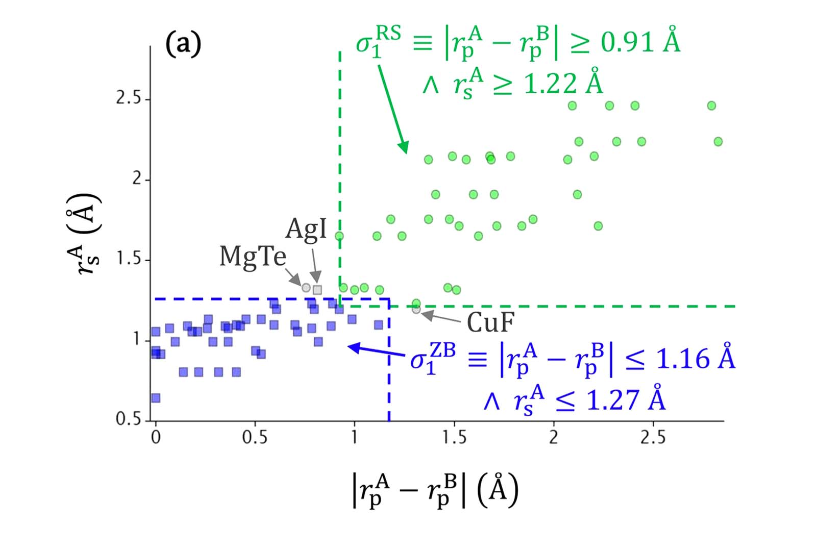

In [5]:
from IPython import display
display.Image("OctetBinaryPlot.png")

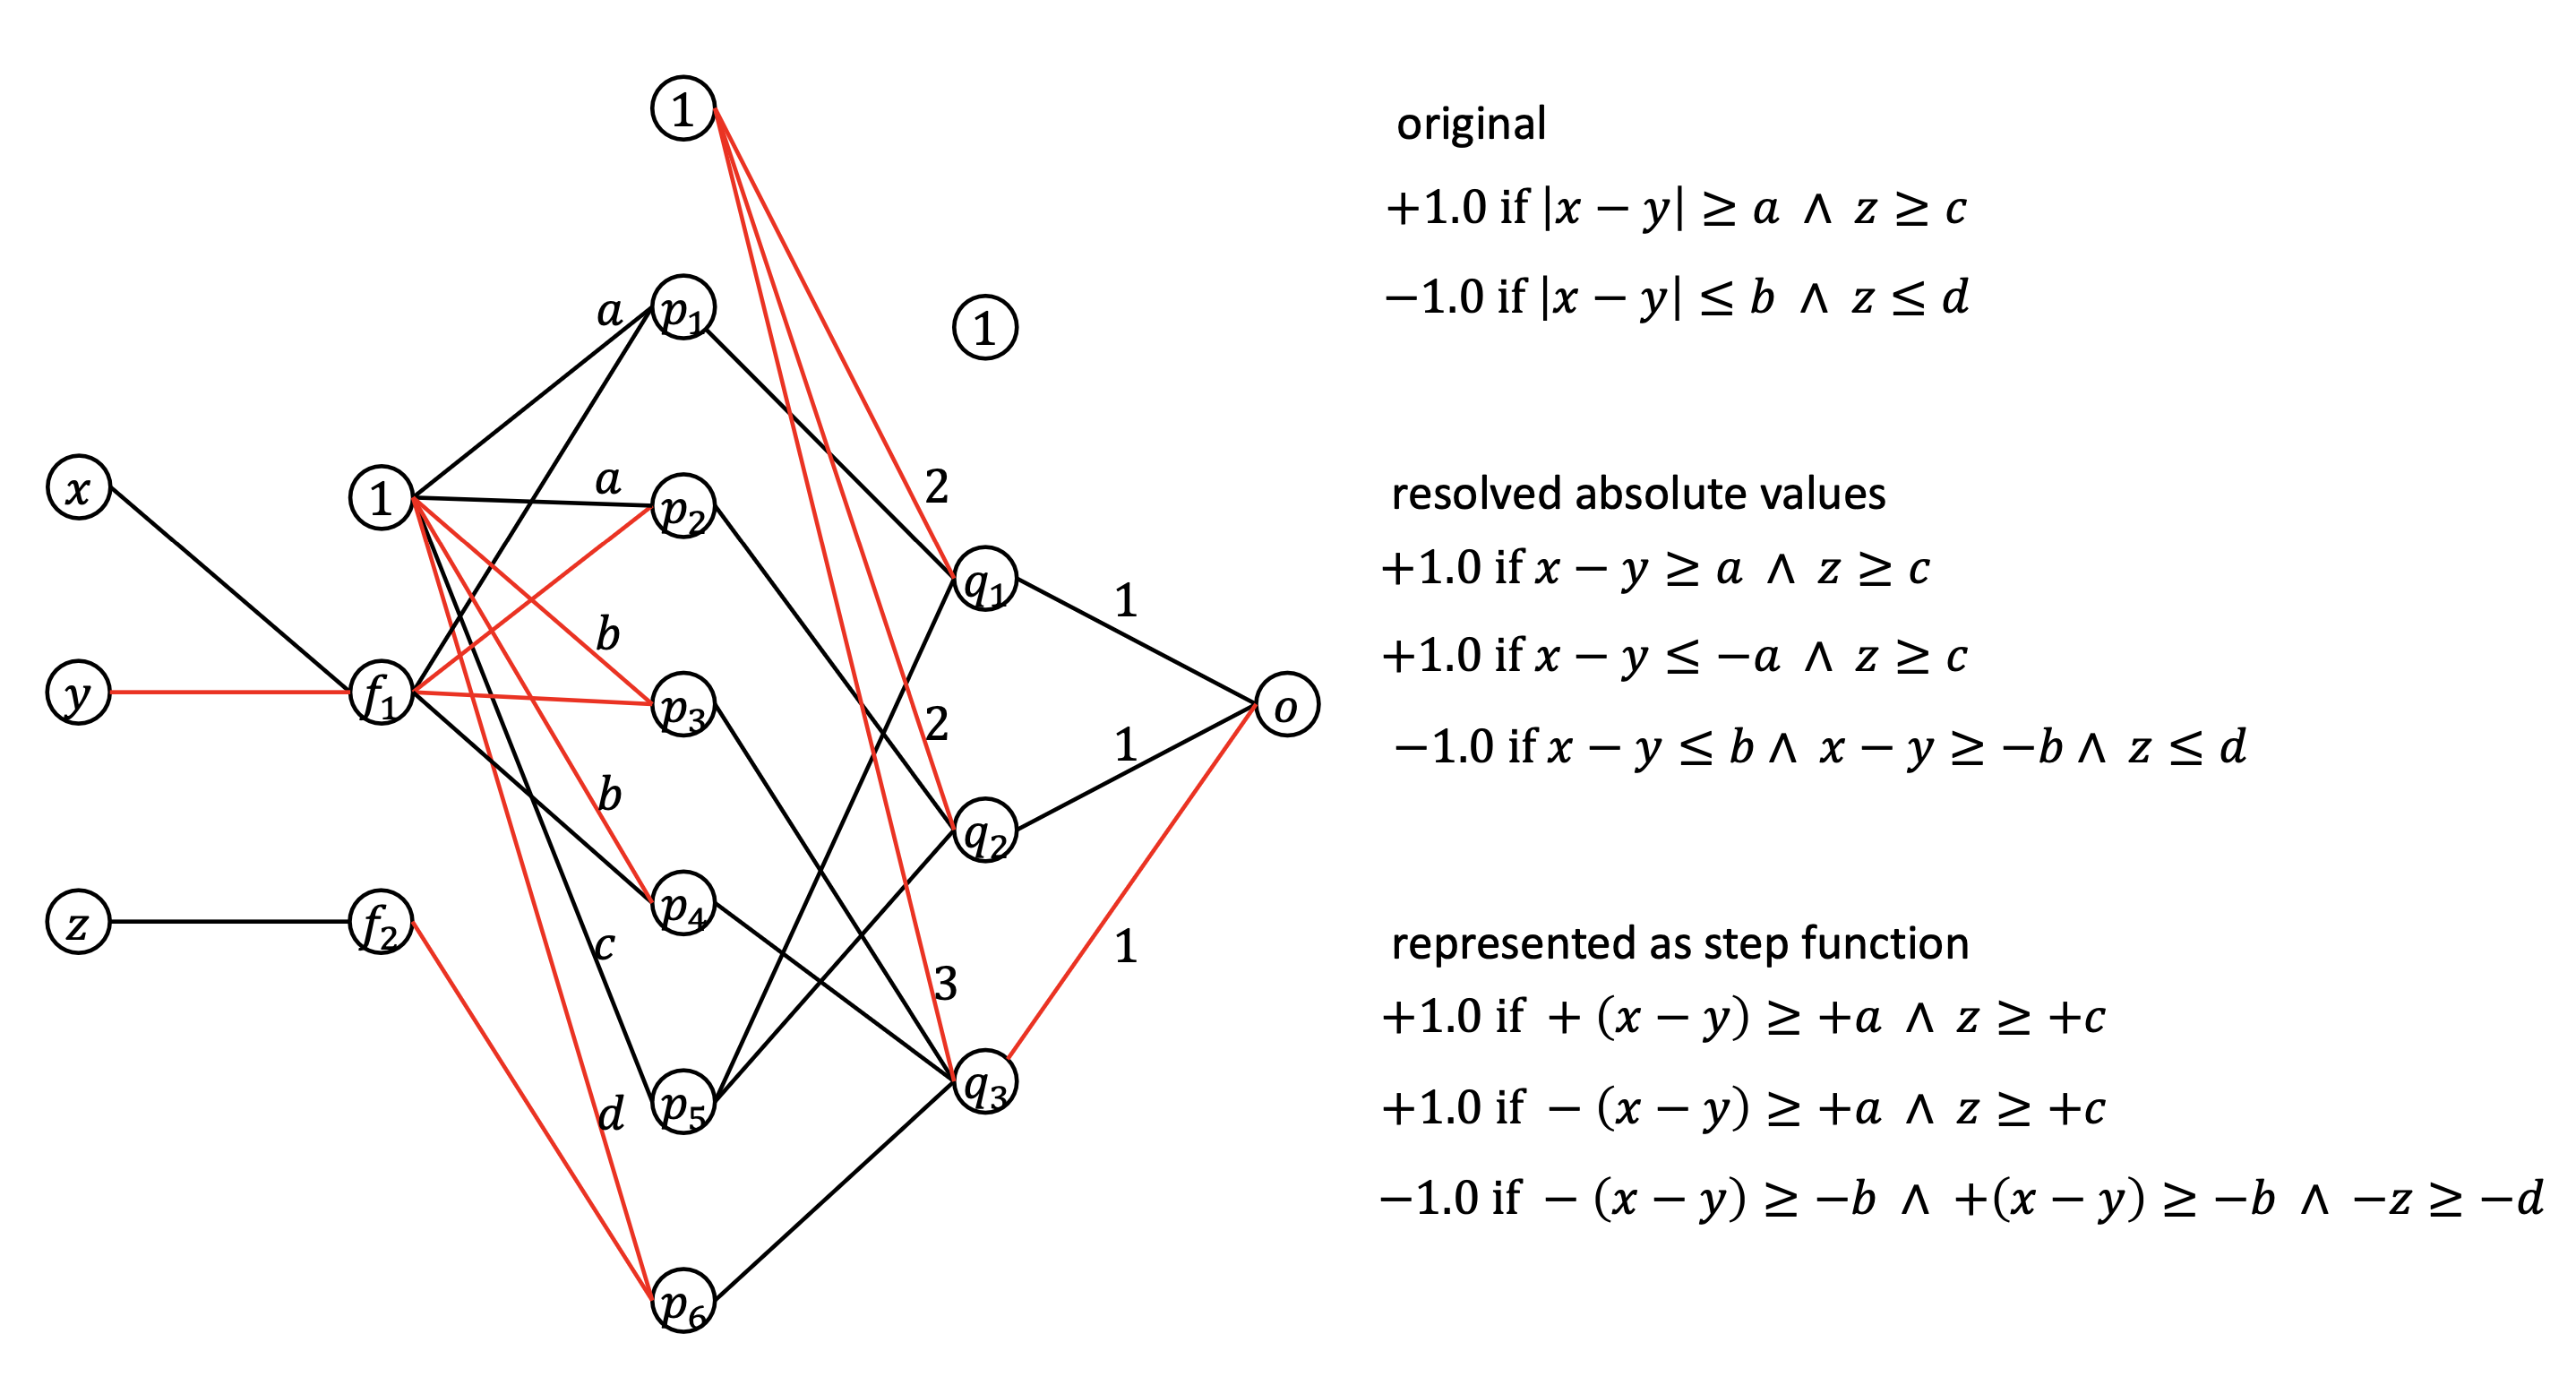

In [6]:
from IPython import display
display.Image("OctetBinary.png")

# Loading Dataset and Transform to Tensor

In [7]:
class OctetBinary(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.n_samples = X.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
    

X = octet_selected[['sigma>0.91', 'sigma<-0.91', 'sigma<1.16', 'sigma>-1.16', 'rs>1.22','rs<1.27']].to_numpy()
y = octet_selected['RS_ZB'].to_numpy()
# y = octet_selected['Delta E'].to_numpy()

RNG = np.random.default_rng(seed=0)
train_ind = RNG.choice(len(X), size=int(len(X)*5), replace=True)
test_ind = np.setdiff1d(np.array(range(len(X))), train_ind)
X_train, X_test, y_train, y_test = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
    
dataset = OctetBinary(X_train, y_train)
dataloader = DataLoader(dataset=dataset, batch_size=int(1*len(X)), shuffle=True)

# Creating the NN Model

In [8]:
class StepActivation(nn.Module):
    def forward(self, x):
        return torch.where(x > 0, torch.tensor(1.0), torch.tensor(0.0))

class BinaryRounding(nn.Module):
    def forward(self, x):
        return torch.where(x >= 0.5, torch.tensor(1.0), torch.tensor(0.0))

class SigmoidMinusOneActivation(torch.nn.Module):
    def forward(self, x):
        return torch.sigmoid(x) - 1


class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bias=False):
        super(RegressionModel, self).__init__()
        self.bias = bias
        self.hidden = nn.Linear(input_size, hidden_size, bias=self.bias)
        # self.hidden = nn.Sequential(
        #     nn.Linear(input_size, hidden_size, bias=self.bias),
        #     nn.Sigmoid()
        # )
        self.output = nn.Linear(hidden_size, output_size, bias=False)

        # # Ground truth weights
        # if idealmodel:
        #     with torch.no_grad():
        #         hidden_weights = torch.tensor([[1,0,0,0,1,0],[0,1,0,0,1,0],[0,0,1,1,0,1]], dtype=torch.float32)
        #         self.hidden[0].weight.data = hidden_weights.clone()
        #         sum_of_weights_hidden = -self.hidden[0].weight.sum(dim=1)
        #         self.hidden[0].bias.data = sum_of_weights_hidden.clone()

        #         output_weights = torch.tensor([[1,1,-1]], dtype=torch.float32)
        #         self.output.weight.data = output_weights.clone()

        
    def forward(self, x):
        x = x - 1
        x = self.hidden(x)
        # x = torch.where(x > 0, torch.tensor(1.0), torch.tensor(0.0))
        x = torch.sigmoid(10*x)
        x = self.output(x)
        # x = torch.tanh(10*x)
        return x

    def l1_loss(self):
        l1_loss = 0.0
        for param in self.parameters():
            l1_loss += torch.sum(torch.abs(param))
        return self.alpha * l1_loss
    
    def binary_loss(self):
        binary_loss = 0.0
        w_ = []
        for name, param in self.named_parameters():
            if name == 'hidden.0.weight':
                w_.append(param.reshape(-1,1))
            
        for v in w_:
            for v_i in v:
                if torch.abs(v_i) < torch.abs(v_i-1):
                    b = 0
                else:
                    b = 1
                binary_loss += torch.sum(torch.tensor(b))
        return binary_loss
    
    
    def round_parameters(self, hidden=True, output=False):
        for name, param in self.named_parameters():
            if name != 'output.weight' and hidden:
                param.data = torch.where(param.data >= 0.5, torch.tensor(1.0), torch.tensor(0.0)) #BinaryRounding.forward(param.data).clone().detach().requires_grad_(True)
            if name == 'output.weight' and output:
                param.data = torch.where(param.data >= 0.0, torch.tensor(1.0), torch.tensor(-1.0))

    def absolute_weights(self):
        for name, param in self.named_parameters():
            if name != 'output.weight':
                param.data = torch.abs(param.data)

    
    def predict(self, input):
        self.eval()
        input = torch.tensor(input, dtype=torch.float32)

        with torch.no_grad():
            output = self.forward(input)

        self.train()
        
        return output.numpy()
    

In [9]:
# input_size = 6
# hidden_size = 3
# output_size = 1

# model = RegressionModel(input_size, hidden_size, output_size, bias=False)

# weights = []
# for name, param in model.named_parameters():
#     if name != 'output.weight':
#         param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)
#     weights.append(param.detach().numpy())
#     print(name, param)

In [10]:
# loss_criterion = nn.MSELoss()
# average_epoch_loss_list = []
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# alpha = 0
# num_epochs = 10000
# gradient_threshold = 1e-16
# epsilon = 1e-3
# for epoch in range(num_epochs):
#     epoch_loss = 0.0
#     for batch_x, batch_y in dataloader:
#         optimizer.zero_grad() 

#         # for name, param in model.named_parameters():
#         #     if name != 'output.weight': 
#         #         unrounded_weights = param.detach()
#         #         rounded_weights = torch.where(param >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
#         #         param.data = rounded_weights
            
#         predictions = model(batch_x)  
#         mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
#         binary_loss = model.binary_loss()
#         total_loss = mse_loss + alpha*binary_loss 
#         total_loss.backward()  

#         # for name, param in model.named_parameters():
#         #     if name != 'output.weight': 
#         #         if param.grad is not None:
#         #             param.grad.data = torch.where(param.grad > 0, torch.tensor(1.0), torch.tensor(0.0))
#         #             param.data = unrounded_weights

#         optimizer.step() 
#         epoch_loss += total_loss.item()

#     average_epoch_loss = epoch_loss / len(dataloader)
#     average_epoch_loss_list.append(average_epoch_loss)

#     if epoch % 1000 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')



# plt.scatter(range(epoch+1), average_epoch_loss_list)
# plt.xlabel('epochs')
# plt.ylabel('(MSE + Regul.)/batch_size')

In [11]:
# weights = []
# for name, param in model.named_parameters():
#     weights.append(param.detach().numpy())
#     print(name, param)

# model.round_parameters(hidden=True, output=True)
# for name, param in model.named_parameters():
#     # weights.append(param.detach().numpy())
#     print(name, param)

In [12]:
# y_pred = model.predict(X_train)
# y_train = y_train.reshape(-1,1)
# print(f'MSE for unrounded parameters is: {(np.mean((y_train-y_pred)**2))}')

In [13]:
# np.random.seed(19680801)
# # yaxis = [np.where(y_train>0.0, 1, -1),np.where(y_pred>0.0, 1, -1)]
# yaxis = [y_train,y_pred]
# axs_title = ['Ground Truth Data Points', 'Predicted Labels from Trained NN']
# fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# for col in range(2):
#     ax = axs[col]
#     pcm = ax.scatter(octet_selected['sigma'][train_ind],octet_selected['rs(A)'][train_ind], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-1, vmax=1)
#     ax.set_title(axs_title[col])

# # fig.suptitle('Prediction over Test Points')
# fig.colorbar(pcm)

# plt.scatter(range(len(y_pred)),y_train, label='TrainPoints')
# plt.scatter(range(len(y_pred)),y_pred, label='Preditions')
# plt.legend()

# Scenario 1: Rounding the Weights After Each Training
1. Initialise the Weights
    
For each loop:

2. $y_{pred} = Model(X,W_t, \theta_t)$ (Froward Step)
3. $loss(y, y_{pred})$ 
4. $\nabla_{w_t} = \frac{\partial loss}{\partial W_t}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
5. $W_{t+1} = W_t + \eta \nabla_{w_t}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

6. $W = Binarise(W_{\tau})$ and $\theta = Sign(\theta_{\tau})$ 

hidden.weight Parameter containing:
tensor([[ 0.2940,  0.3154, -0.0953,  0.3152, -0.0629, -0.3243],
        [ 0.3064,  0.1157, -0.0201, -0.0356,  0.1103,  0.3815],
        [ 0.1592,  0.3040,  0.1075,  0.3217, -0.0539,  0.3327]],
       requires_grad=True)
output.weight Parameter containing:
tensor([[ 0.4174,  0.0602, -0.0157]], requires_grad=True)
Epoch [1/10000] Loss: 0.7338
Epoch [1001/10000] Loss: 0.0867
Epoch [2001/10000] Loss: 0.0021
Epoch [3001/10000] Loss: 0.0000
Epoch [4001/10000] Loss: 0.0000
Epoch [5001/10000] Loss: 0.0000
Epoch [6001/10000] Loss: 0.0000
Epoch [7001/10000] Loss: 0.0000
Epoch [8001/10000] Loss: 0.0000
Epoch [9001/10000] Loss: 0.0000
hidden.weight Parameter containing:
tensor([[1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1.]], requires_grad=True)
output.weight Parameter containing:
tensor([[ 1.,  1., -1.]], requires_grad=True)
The MSE is 0.1250


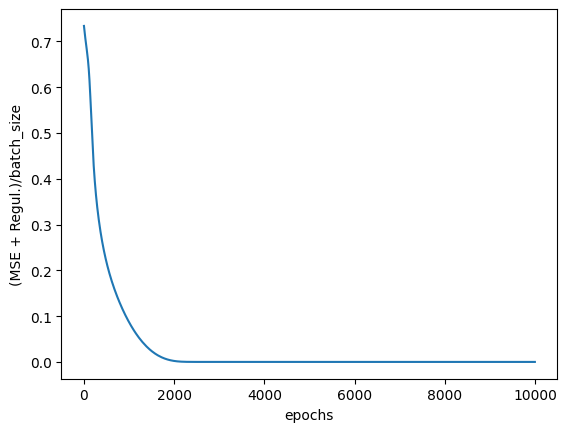

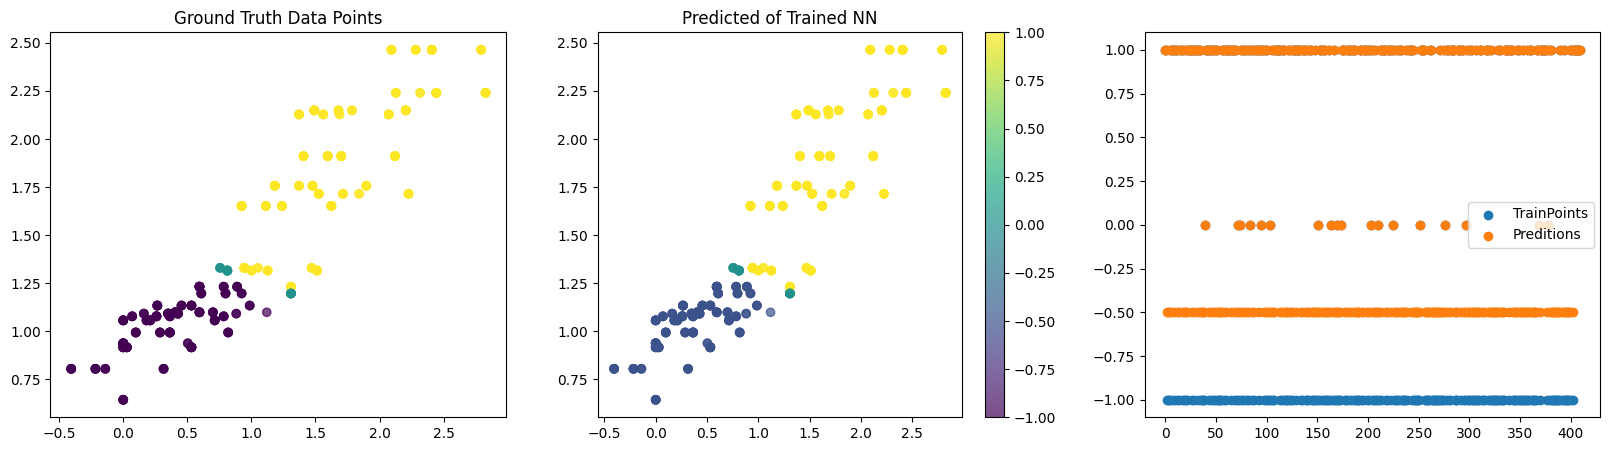

In [14]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
alpha = 0
num_epochs = 10000
model_1 = RegressionModel(input_size, hidden_size, output_size, bias=False)
for name, param in model_1.named_parameters():
    print(name, param)

optimizer = torch.optim.Adam(model_1.parameters(), lr=0.0001)
average_epoch_loss_list_1 = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad() 
        predictions = model_1.forward(batch_x)  
        mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
        binary_loss = model_1.binary_loss()
        total_loss = mse_loss + alpha*binary_loss 
        total_loss.backward()  
        optimizer.step() 
        epoch_loss += total_loss.item()

    average_epoch_loss = epoch_loss / len(dataloader)
    average_epoch_loss_list_1.append(average_epoch_loss)
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')

plt.plot(range(epoch+1), average_epoch_loss_list_1)
plt.xlabel('epochs')
plt.ylabel('(MSE + Regul.)/batch_size')

model_1.round_parameters(hidden=True, output=True)
for name, param in model_1.named_parameters():
    print(name, param)
y_pred_1 = model_1.predict(X_train)
y_train = y_train.reshape(-1,1)
mse_1 = np.mean((y_train-y_pred_1)**2)
print(f'The MSE is {mse_1:.4f}')

np.random.seed(19680801)
# yaxis = [np.where(y_train>0.0, 1, -1),np.where(y_pred>0.0, 1, -1)]
yaxis = [y_train,y_pred_1]
axs_title = ['Ground Truth Data Points', 'Predicted of Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'][train_ind],octet_selected['rs(A)'][train_ind], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-1, vmax=1)
    ax.set_title(axs_title[col])

fig.colorbar(pcm)
axs[2].scatter(range(len(y_pred_1)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_pred_1)),y_pred_1, label='Preditions')
axs[2].legend()

# Scenario 2: Rounding the Proposition Layer Weights in Each Training Loop before Forward Step
1. Initialise the Weights (Intentionally we choose random integers from -1 to 1 for hidden layer)

For each epoch:

2. $W_b = Binarise(W_t)$
3. $y_{pred} = Model(X,W_b, \theta_t)$ (Froward Step)
4. $loss(y, y_{pred})$ 
5. $\nabla_{w_b} = \frac{\partial loss}{\partial W_b}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
6. $W_{b+1} = W_b + \eta \nabla_{w_b}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

7. $W = Binarise(W_{\tau})$ and $\theta = Sign(\theta_{\tau})$ 

hidden.weight Parameter containing:
tensor([[ 0.,  0., -1.,  0.,  1.,  0.],
        [ 0.,  1., -1.,  0., -1.,  0.],
        [-1., -1.,  1., -1., -1.,  1.]], requires_grad=True)
output.weight Parameter containing:
tensor([[0.1882, 0.0017, 0.5116]], requires_grad=True)
Epoch [1/10000] Loss: 1.1736
Epoch [1001/10000] Loss: 0.7563
Epoch [2001/10000] Loss: 0.4534
Epoch [3001/10000] Loss: 0.2521
Epoch [4001/10000] Loss: 0.1342
Epoch [5001/10000] Loss: 0.0742
Epoch [6001/10000] Loss: 0.0586
Epoch [7001/10000] Loss: 0.0583
Epoch [8001/10000] Loss: 0.0583
Epoch [9001/10000] Loss: 0.0583
hidden.weight Parameter containing:
tensor([[0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1.]], requires_grad=True)
output.weight Parameter containing:
tensor([[ 1., -1., -1.]], requires_grad=True)
The MSE is 0.2787


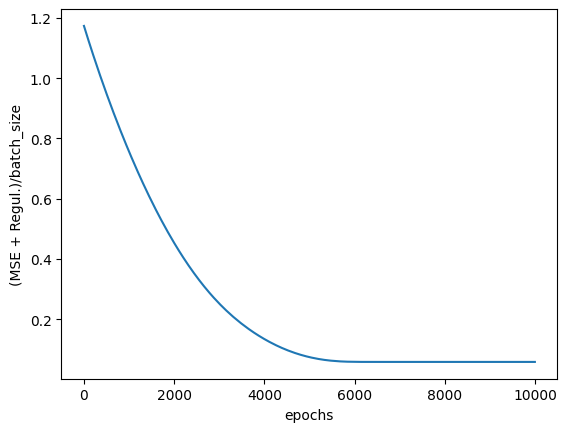

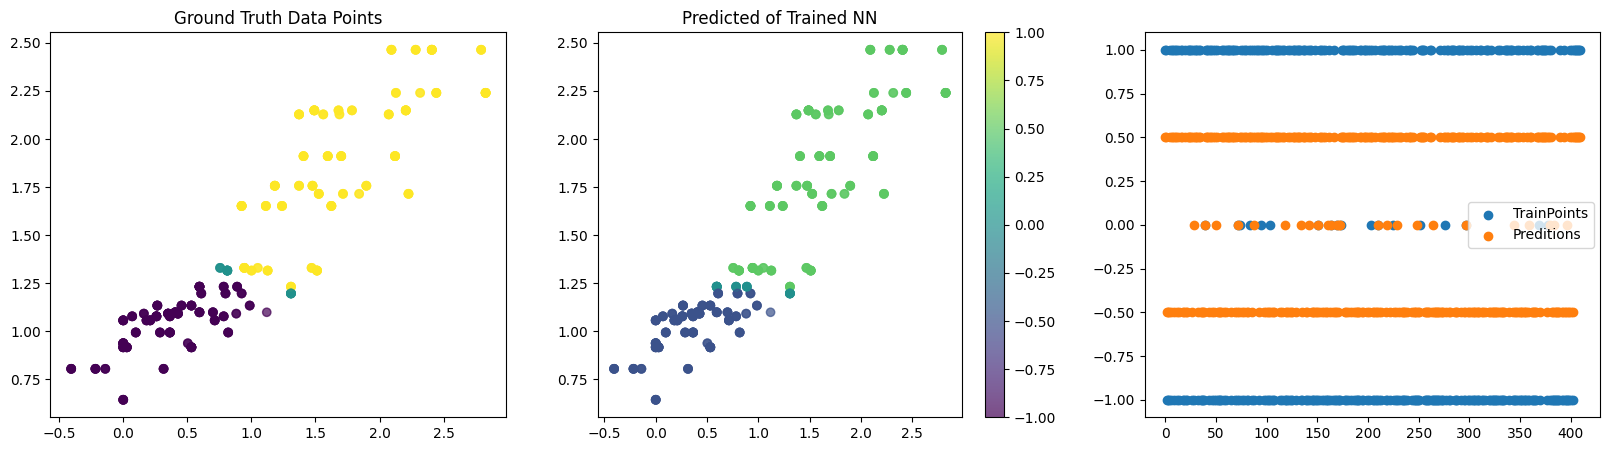

In [15]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
alpha = 0
num_epochs = 10000
model_2 = RegressionModel(input_size, hidden_size, output_size, bias=False)
for name, param in model_2.named_parameters():
    if name != 'output.weight':
        param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)
    print(name, param)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0001)
average_epoch_loss_list_2 = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad() 
        for name, param in model_2.named_parameters():
            if name != 'output.weight': 
                rounded_weights = torch.where(param >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
                param.data = rounded_weights
                
        predictions = model_2.forward(batch_x)  
        mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
        binary_loss = model_2.binary_loss()
        total_loss = mse_loss + alpha*binary_loss 
        total_loss.backward()  
        optimizer.step() 
        epoch_loss += total_loss.item()

    average_epoch_loss = epoch_loss / len(dataloader)
    average_epoch_loss_list_2.append(average_epoch_loss)
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')

plt.plot(range(epoch+1), average_epoch_loss_list_2)
plt.xlabel('epochs')
plt.ylabel('(MSE + Regul.)/batch_size')

model_2.round_parameters(hidden=True, output=True)
for name, param in model_2.named_parameters():
    print(name, param)
y_pred_2 = model_2.predict(X_train)
y_train = y_train.reshape(-1,1)
mse_2 = np.mean((y_train-y_pred_2)**2)
print(f'The MSE is {mse_2:.4f}')

np.random.seed(19680801)
# yaxis = [np.where(y_train>0.0, 1, -1),np.where(y_pred>0.0, 1, -1)]
yaxis = [y_train,y_pred_2]
axs_title = ['Ground Truth Data Points', 'Predicted of Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'][train_ind],octet_selected['rs(A)'][train_ind], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-1, vmax=1)
    ax.set_title(axs_title[col])

fig.colorbar(pcm)
axs[2].scatter(range(len(y_pred_2)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_pred_2)),y_pred_2, label='Preditions')
axs[2].legend()

# Scenario 3: Rounding the Proposition Layer Weights before Forward Step and Update the nonbinarized Weight
1- Initialise the Weights (Intentionally we choose random integers from -1 to 1 for hidden layer)

For each epoch:

2. Keeping $W_t, \theta_t$ 
3. $W_b = Binarise(W_t)$ 
4. $y_{pred} = Model(X,W_b, \theta_t)$ (Froward Step)
5. $loss(y, y_{pred})$ 
6. $\nabla_{w_b} = \frac{\partial loss}{\partial W_b}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
7. $W_{t+1} = W_t + \eta \nabla_{w_b}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

8. $W = Binarise(W_{\tau})$ and $\theta = Sign(\theta_{\tau})$ 

hidden.weight Parameter containing:
tensor([[-1.,  1., -1.,  1.,  1., -1.],
        [-1., -1., -1.,  0., -1.,  1.],
        [ 0.,  0.,  0., -1.,  1., -1.]], requires_grad=True)
output.weight Parameter containing:
tensor([[ 0.3497, -0.3535,  0.4716]], requires_grad=True)
Epoch [1/10000] Loss: 0.6295
Epoch [1001/10000] Loss: 0.3093
Epoch [2001/10000] Loss: 0.1295
Epoch [3001/10000] Loss: 0.0403
Epoch [4001/10000] Loss: 0.0000
Epoch [5001/10000] Loss: 0.0000
Epoch [6001/10000] Loss: 0.0000
Epoch [7001/10000] Loss: 0.0000
Epoch [8001/10000] Loss: 0.0000
Epoch [9001/10000] Loss: 0.0000
hidden.weight Parameter containing:
tensor([[0., 1., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0., 1.],
        [1., 0., 0., 0., 1., 0.]], requires_grad=True)
output.weight Parameter containing:
tensor([[ 1., -1.,  1.]], requires_grad=True)
The MSE is 0.2390


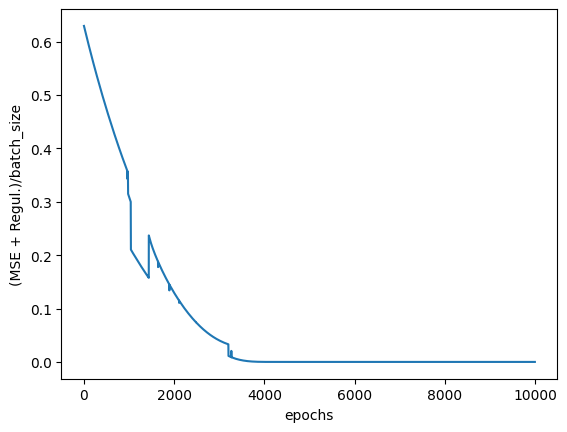

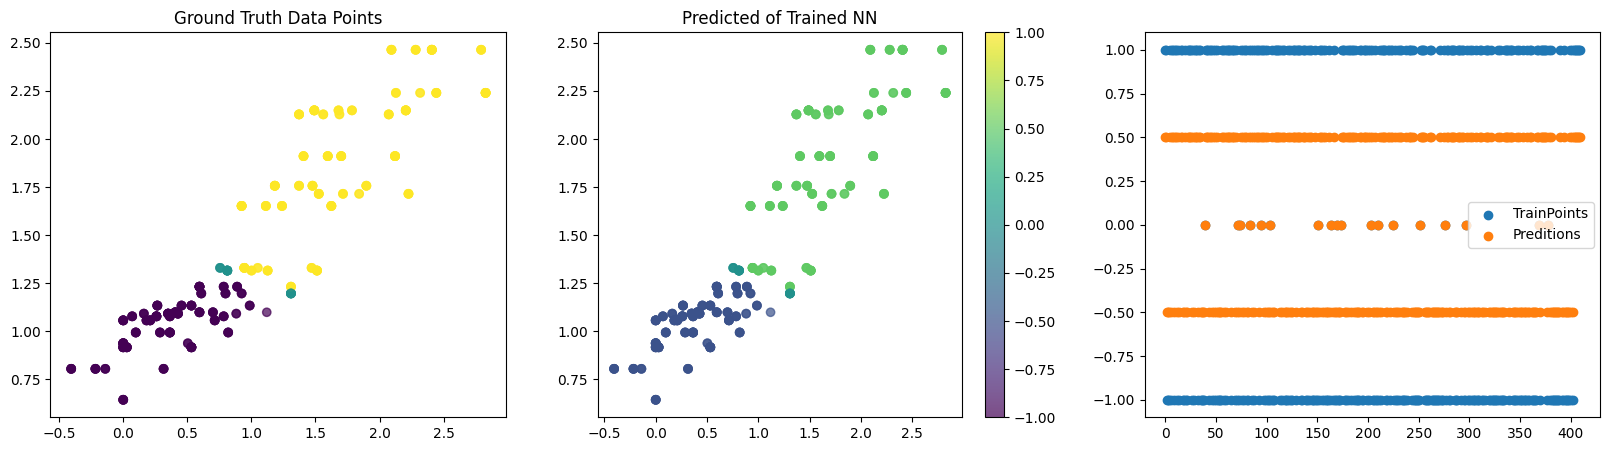

In [16]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
alpha = 0
num_epochs = 10000
model_3 = RegressionModel(input_size, hidden_size, output_size, bias=False)
for name, param in model_3.named_parameters():
    if name != 'output.weight':
        param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)
    print(name, param)
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)
average_epoch_loss_list_3 = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad() 

        for name, param in model_3.named_parameters():
            if name != 'output.weight':
                unrounded_weights = param.detach()
                rounded_weights = torch.where(param >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
                param.data = rounded_weights
                
        predictions = model_3.forward(batch_x)  
        mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
        binary_loss = model_3.binary_loss()
        total_loss = mse_loss + alpha*binary_loss 
        total_loss.backward()  

        for name, param in model_3.named_parameters():
            if name != 'output.weight': 
                if param.grad is not None:
                    param.data = unrounded_weights

        optimizer.step() 
        epoch_loss += total_loss.item()

    average_epoch_loss = epoch_loss / len(dataloader)
    average_epoch_loss_list_3.append(average_epoch_loss)
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')

plt.plot(range(epoch+1), average_epoch_loss_list_3)
plt.xlabel('epochs')
plt.ylabel('(MSE + Regul.)/batch_size')

model_3.round_parameters(hidden=True, output=True)
for name, param in model_3.named_parameters():
    print(name, param)
y_pred_3 = model_3.predict(X_train)
y_train = y_train.reshape(-1,1)
mse_3 = np.mean((y_train-y_pred_3)**2)
print(f'The MSE is {mse_3:.4f}')

np.random.seed(19680801)
# yaxis = [np.where(y_train>0.0, 1, -1),np.where(y_pred>0.0, 1, -1)]
yaxis = [y_train,y_pred_3]
axs_title = ['Ground Truth Data Points', 'Predicted of Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'][train_ind],octet_selected['rs(A)'][train_ind], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-1, vmax=1)
    ax.set_title(axs_title[col])

fig.colorbar(pcm)
axs[2].scatter(range(len(y_train)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_train)),y_pred_3, label='Preditions')
axs[2].legend()

# Scenario 4: Using Binary Penalty and Rounding the Weights After Each Training
1. Initialise the Weights
    
For each loop:

2. $y_{pred} = Model(X,W_t, \theta_t)$ (Froward Step)
3. $loss(y, y_{pred})+p(W_t)$ 
4. $\nabla_{w_t} = \frac{\partial loss}{\partial W_t}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
5. $W_{t+1} = W_t + \eta \nabla_{w_t}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

6. $W = Binarise(W_{\tau})$ and $\theta = Sign(\theta_{\tau})$ 

hidden.weight Parameter containing:
tensor([[-0.0743, -0.2662,  0.1986, -0.1907, -0.2591, -0.2458],
        [-0.0186,  0.0107,  0.3453,  0.3231,  0.1014, -0.0158],
        [ 0.0466, -0.3077,  0.3558,  0.2404, -0.1340, -0.1135]],
       requires_grad=True)
output.weight Parameter containing:
tensor([[-0.1280,  0.4892, -0.1690]], requires_grad=True)
Epoch [1/10000] Loss: 1.0133
Epoch [1001/10000] Loss: 0.0113
Epoch [2001/10000] Loss: 0.0007
Epoch [3001/10000] Loss: 0.0001
Epoch [4001/10000] Loss: 0.0000
Epoch [5001/10000] Loss: 0.0000
Epoch [6001/10000] Loss: 0.0000
Epoch [7001/10000] Loss: 0.0000
Epoch [8001/10000] Loss: 0.0000
Epoch [9001/10000] Loss: 0.0000
hidden.weight Parameter containing:
tensor([[0., 0., 1., 0., 0., 1.],
        [1., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1.]], requires_grad=True)
output.weight Parameter containing:
tensor([[-1.,  1., -1.]], requires_grad=True)
The MSE is 0.1140


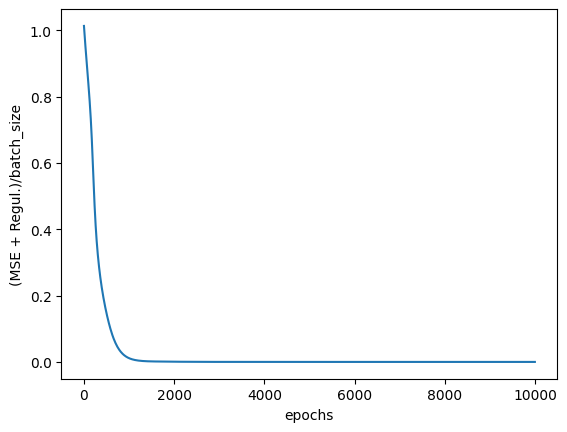

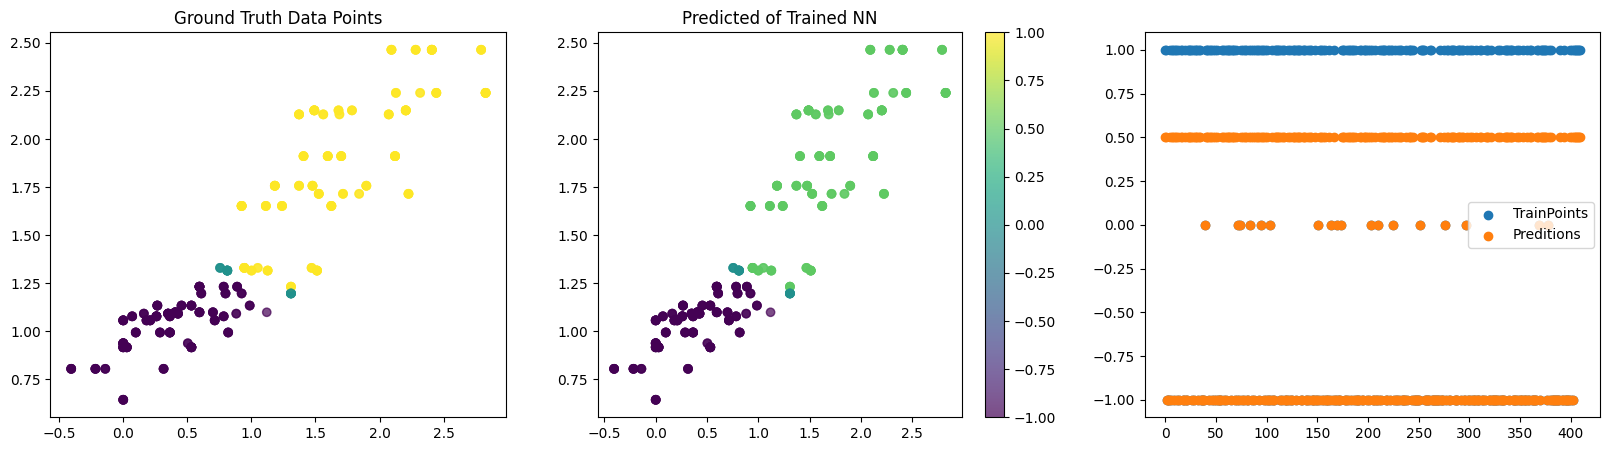

In [17]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
alpha = 0.01
num_epochs = 10000
model_4 = RegressionModel(input_size, hidden_size, output_size, bias=False)
for name, param in model_4.named_parameters():
    print(name, param)

optimizer = torch.optim.Adam(model_4.parameters(), lr=0.0001)
average_epoch_loss_list_4 = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad() 
        predictions = model_4.forward(batch_x)  
        mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
        binary_loss = model_4.binary_loss()
        total_loss = mse_loss + alpha*binary_loss 
        total_loss.backward()  
        optimizer.step() 
        epoch_loss += total_loss.item()

    average_epoch_loss = epoch_loss / len(dataloader)
    average_epoch_loss_list_4.append(average_epoch_loss)
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')

plt.plot(range(epoch+1), average_epoch_loss_list_4)
plt.xlabel('epochs')
plt.ylabel('(MSE + Regul.)/batch_size')

model_4.round_parameters(hidden=True, output=True)
for name, param in model_4.named_parameters():
    print(name, param)
y_pred_4 = model_4.predict(X_train)
y_train = y_train.reshape(-1,1)
mse_4 = np.mean((y_train-y_pred_4)**2)
print(f'The MSE is {mse_4:.4f}')

np.random.seed(19680801)
# yaxis = [np.where(y_train>0.0, 1, -1),np.where(y_pred>0.0, 1, -1)]
yaxis = [y_train,y_pred_4]
axs_title = ['Ground Truth Data Points', 'Predicted of Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'][train_ind],octet_selected['rs(A)'][train_ind], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-1, vmax=1)
    ax.set_title(axs_title[col])

fig.colorbar(pcm)
axs[2].scatter(range(len(y_train)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_pred_4)),y_pred_4, label='Preditions')
axs[2].legend()

In [18]:
# input_size = 6
# hidden_size = 3
# output_size = 1
# loss_criterion = nn.MSELoss()
# alpha = 0
# num_epochs = 10000
# MSElist = []
# w_per_rep = []
# for reps in range(100):
#     model_3 = RegressionModel(input_size, hidden_size, output_size, bias=False)
#     for name, param in model_3.named_parameters():
#         if name != 'output.weight':
#             param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)

#     optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)
#     average_epoch_loss_list_3 = []

#     for epoch in range(num_epochs):
#         epoch_loss = 0.0
#         for batch_x, batch_y in dataloader:
#             optimizer.zero_grad() 

#             for name, param in model_3.named_parameters():
#                 if name != 'output.weight':
#                     unrounded_weights = param.detach()
#                     rounded_weights = torch.where(param >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
#                     param.data = rounded_weights
                    
#             predictions = model_3(batch_x)  
#             mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
#             binary_loss = model_3.binary_loss()
#             total_loss = mse_loss + alpha*binary_loss 
#             total_loss.backward()  

#             for name, param in model_3.named_parameters():
#                 if name != 'output.weight': 
#                     if param.grad is not None:
#                         param.data = unrounded_weights

#             optimizer.step() 
#             epoch_loss += total_loss.item()

#         average_epoch_loss = epoch_loss / len(dataloader)
#         average_epoch_loss_list_3.append(average_epoch_loss)
#         # if epoch % 1000 == 0:
#         #     print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')

#     model_3.round_parameters(hidden=True, output=True)
#     w_ = []
#     for name, param in model_3.named_parameters():
#         w_.append(param.detach().numpy())
#     w_per_rep.append(w_)
#     y_pred_3 = model_3.predict(X_train)
#     y_train = y_train.reshape(-1,1)
#     mse_3 = np.mean((y_train-y_pred_3)**2)
#     MSElist.append(mse_3)
#     print(f'Reps: {reps}')



# ws = []
# tetas = []

# for row, w in enumerate(w_per_rep):
#     ws.append(w[0])
#     tetas.append(w[1])

# ws = np.array(ws)
# tetas = np.array(tetas)
# # np.unique(tetas, axis=0, return_counts=True, return_index=True)
# a,indices,counts = np.unique(ws, axis=0, return_counts=True, return_index=True)
# ws[indices[np.argmax(counts)]]
# counts

# Scenario 5: Using SignSwish Activation

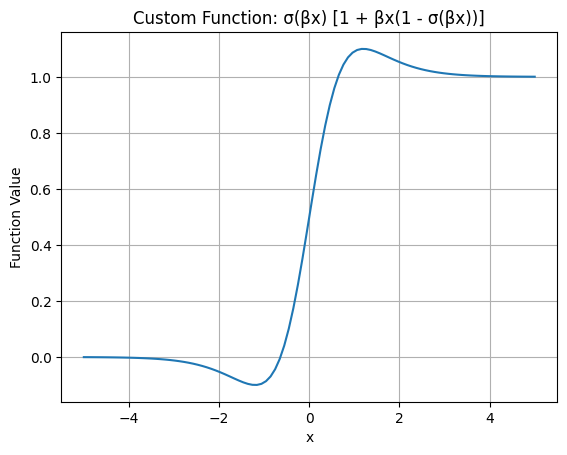

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z, alpha):
    return 1 / (1 + np.exp(-alpha*z))

def SignSwish(x, beta, alpha):
    z = beta * x
    return sigmoid(z, alpha) * (1 + z * (1 - sigmoid(z,alpha)))


x_values = np.linspace(-5, 5, 100)  
y_values = [SignSwish(x, beta=2, alpha=1) for x in x_values]

# Create the plot
plt.plot(x_values, y_values)
plt.title('Custom Function: σ(βx) [1 + βx(1 - σ(βx))]')
plt.xlabel('x')
plt.ylabel('Function Value')

# Show the plot
plt.grid(True)
plt.show()


In [48]:
def SSwish(x, beta, alpha):
    z = beta * x
    return torch.sigmoid(alpha*z) * (1 + z * (1 - torch.sigmoid(alpha*z)))

class BinaryNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bias=False):
        super(BinaryNN, self).__init__()
        self.bias = bias
        self.hidden = nn.Linear(input_size, hidden_size, bias=self.bias)
        self.output = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x, training=True):
        x = x - 1
        x = self.hidden(x)
        if training:
            x = SSwish(x, beta=2, alpha=1)
        else:
            # x = torch.where(x>=0, torch.tensor(1.0), torch.tensor(0.0))
            x = torch.sigmoid(10*x)
        x = self.output(x)
        # x = torch.tanh(10*x)
        return x

    def l1_loss(self):
        l1_loss = 0.0
        for param in self.parameters():
            l1_loss += torch.sum(torch.abs(param))
        return self.alpha * l1_loss
    
    def binary_loss(self):
        binary_loss = 0.0
        w_ = []
        for name, param in self.named_parameters():
            if name == 'hidden.0.weight':
                w_.append(param.reshape(-1,1))
            
        for v in w_:
            for v_i in v:
                if torch.abs(v_i) < torch.abs(v_i-1):
                    b = 0
                else:
                    b = 1
                binary_loss += torch.sum(torch.tensor(b))
        return binary_loss
    
    
    def round_parameters(self, hidden=True, output=False):
        for name, param in self.named_parameters():
            if name != 'output.weight' and hidden:
                param.data = torch.where(param.data >= 0.5, torch.tensor(1.0), torch.tensor(0.0)) #BinaryRounding.forward(param.data).clone().detach().requires_grad_(True)
            if name == 'output.weight' and output:
                param.data = torch.where(param.data >= 0.0, torch.tensor(1.0), torch.tensor(-1.0))

    def absolute_weights(self):
        for name, param in self.named_parameters():
            if name != 'output.weight':
                param.data = torch.abs(param.data)

    
    def predict(self, input):
        self.eval()
        input = torch.tensor(input, dtype=torch.float32)

        with torch.no_grad():
            output = self.forward(input, training=False)

        self.train()
        
        return output.numpy()
    

hidden.weight Parameter containing:
tensor([[ 0.,  0.,  1.,  1.,  0.,  1.],
        [ 1.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  1.,  1., -1.,  1.,  1.]], requires_grad=True)
output.weight Parameter containing:
tensor([[-0.1990, -0.0238, -0.2533]], requires_grad=True)
Epoch [1/10000] Loss: 0.8714
Epoch [1001/10000] Loss: 0.4446
Epoch [2001/10000] Loss: 0.1717
Epoch [3001/10000] Loss: 0.0429
Epoch [4001/10000] Loss: 0.0097
Epoch [5001/10000] Loss: 0.0005
Epoch [6001/10000] Loss: 0.0058
Epoch [7001/10000] Loss: 0.0005
Epoch [8001/10000] Loss: 0.0006
Epoch [9001/10000] Loss: 0.0005
hidden.weight Parameter containing:
tensor([[0., 0., 1., 1., 0., 1.],
        [1., 0., 0., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1.]], requires_grad=True)
output.weight Parameter containing:
tensor([[-1.,  1.,  1.]], requires_grad=True)
The MSE is 0.2391


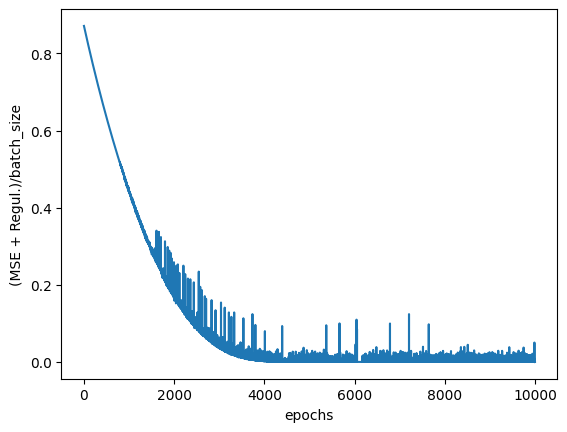

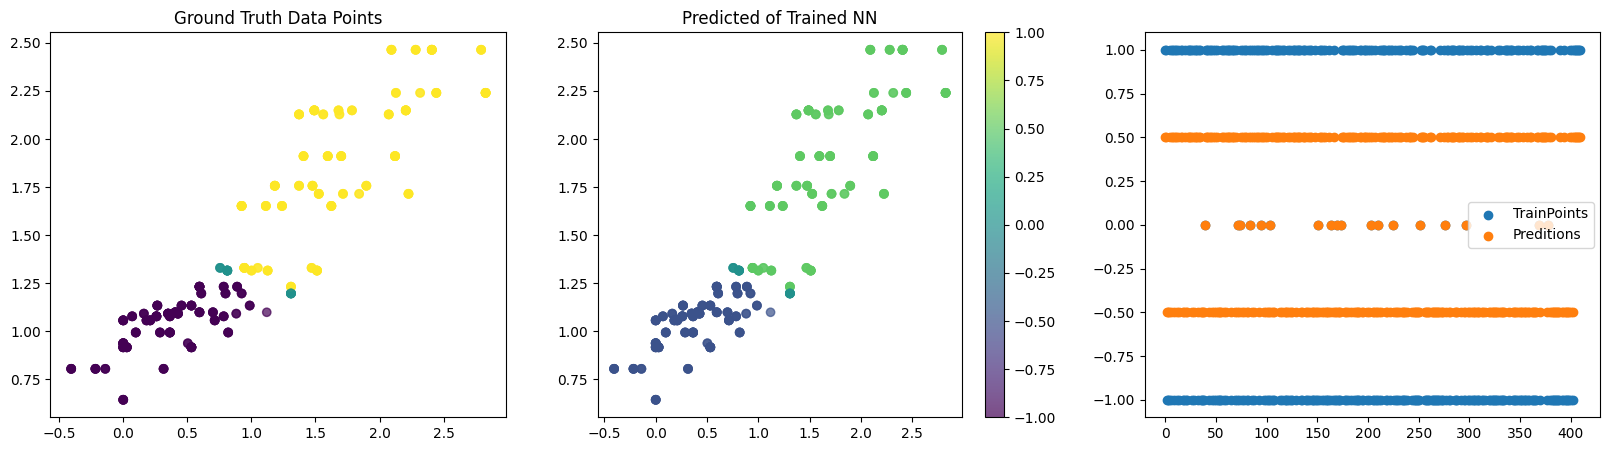

In [49]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
lam = 0.0
num_epochs = 10000
model_5 = BinaryNN(input_size, hidden_size, output_size, bias=False)
for name, param in model_5.named_parameters():
    if name != 'output.weight':
        param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)
    print(name, param)

optimizer = torch.optim.Adam(model_5.parameters(), lr=0.0001)
average_epoch_loss_list_5 = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad() 

        for name, param in model_5.named_parameters():
            if name != 'output.weight':
                unrounded_weights = param.detach()
                rounded_weights = torch.where(param >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
                param.data = rounded_weights

        predictions = model_5.forward(batch_x)  
        mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
        binary_loss = model_5.binary_loss()
        total_loss = mse_loss + lam*binary_loss 
        total_loss.backward()  

        for name, param in model_5.named_parameters():
            if name != 'output.weight': 
                if param.grad is not None:
                    param.data = unrounded_weights

        optimizer.step() 
        epoch_loss += total_loss.item()

    average_epoch_loss = epoch_loss / len(dataloader)
    average_epoch_loss_list_5.append(average_epoch_loss)
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')

plt.plot(range(epoch+1), average_epoch_loss_list_5)
plt.xlabel('epochs')
plt.ylabel('(MSE + Regul.)/batch_size')

model_5.round_parameters(hidden=True, output=True)
for name, param in model_5.named_parameters():
    print(name, param)
y_pred_5 = model_5.predict(X_train)
y_train = y_train.reshape(-1,1)
mse_5 = np.mean((y_train-y_pred_5)**2)
print(f'The MSE is {mse_5:.4f}')

np.random.seed(19680801)
# yaxis = [np.where(y_train>0.0, 1, -1),np.where(y_pred>0.0, 1, -1)]
yaxis = [y_train,y_pred_5]
axs_title = ['Ground Truth Data Points', 'Predicted of Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'][train_ind],octet_selected['rs(A)'][train_ind], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-1, vmax=1)
    ax.set_title(axs_title[col])

fig.colorbar(pcm)
axs[2].scatter(range(len(y_train)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_pred_5)),y_pred_5, label='Preditions')
axs[2].legend()